In [46]:
# run dependencies
!pip install xgboost
!pip install shap

import pandas as pd
import numpy as np
from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import xgboost
import shap

import matplotlib.pyplot as plt

In [69]:
# CSV FILES
player_appearances_csv = "Data/player_appearances.csv"
players_csv = "Data/players.csv"
matches_csv = "Data/matches.csv"
data2021_csv = "Data/Players_EAFIFA/2021.csv"

In [70]:
# READ CSV FILES
playerApps_df = pd.read_csv(player_appearances_csv)
player_df = pd.read_csv(players_csv)
data_df = pd.read_csv(data2021_csv)
matches_df = pd.read_csv(matches_csv)

# CLEAN UP 
playerApps_df["Name"] = playerApps_df["given_name"] + " " + playerApps_df["family_name"]

dict = {'Overal': 'Overall',
        'Natinality': 'Country'}
data_df.rename(columns=dict,inplace = True)


pd.set_option('display.max_columns', None)

In [71]:
# CREATE GROUPED DATAFRAME SHOWING LIFETIME NUMBER OF WORLD CUP MATCHES 
playersApps_df_grp = playerApps_df[["match_id", "player_id", "Name"]].\
                            groupby(["player_id", "Name"]).nunique("match_id")
# playersApps_df_grp

In [72]:

# IDENTIFYING 2022 WORLD CUP QUALIFYING TEAMS
teams_2022 = ['Qatar', 'Netherlands', 'Senegal', 'Ecuador', 
            'England', 'United States', 'Wales', 'Iran', 
            'Argentina', 'Poland', 'Mexico', 'Saudi Arabia', 
            'France', 'Denmark', 'Tunisia', 'Australia', 
            'Germany', 'Spain', 'Japan', 'Costa Rica', 
            'Belgium', 'Croatia', 'Canada', 'Morocco', 
            'Brazil', 'Switzerland', 'Serbia', 'Cameroon', 
            'Portugal', 'Uruguay', 'Ghana', 'Korea Republic']

In [93]:
# MERGING DATAFRAMES

# MERGE PLAYER APPEARNACES WITH PLAYER DATA TO GET ADDITIONAL DETAIL PER PLAYER
player_info_df = pd.merge(playerApps_df, player_df, on = "player_id", how= "inner")

# MERGE NUMBER LIFETIME NUMBER OF WORLD CUP MATCHES ONTO PLAYER RECORDS FROM FIFA 2021 PLAYER SET
df_wc = pd.merge(data_df,playersApps_df_grp, on="Name", how="left")
df_wc = df_wc.rename(columns={"match_id":"Lifetime_WC_Matches"})

df_wc.loc[df_wc["Lifetime_WC_Matches"].notnull(), "Lifetime_WC_Matches_Bin"]=1

df_wc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19120 entries, 0 to 19119
Data columns (total 62 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       19120 non-null  int64  
 1   Name                     19120 non-null  object 
 2   Country                  19120 non-null  object 
 3   Overall                  19120 non-null  int64  
 4   Potential                19120 non-null  int64  
 5   Height                   19120 non-null  int64  
 6   Weight                   19120 non-null  int64  
 7   PreferredFoot            19120 non-null  object 
 8   BirthDate                19120 non-null  object 
 9   Age                      19120 non-null  int64  
 10  PreferredPositions       19120 non-null  object 
 11  PlayerWorkRate           19120 non-null  object 
 12  WeakFoot                 19120 non-null  int64  
 13  SkillMoves               19120 non-null  int64  
 14  Value                 

In [94]:
# VIEW DATAFRAMES

# playerApps_df.head()
# player_info_df.head()
# matches_df.head()
# data_df.head()
# df_wc.head()
player_df.head()

,key_id,player_id,family_name,given_name,birth_date,goal_keeper,defender,midfielder,forward,count_tournaments,list_tournaments,player_wikipedia_link
0,1,P-05074,A'Court,Alan,1934-09-30,0,0,0,1,1,1958,https://en.wikipedia.org/wiki/Alan_A%27Court
1,2,P-00942,Abadzhiev,Stefan,1934-07-03,0,0,0,1,1,1966,https://en.wikipedia.org/wiki/Stefan_Abadzhiev
2,3,P-03051,Abalo,Jean-Paul,1975-06-26,0,1,0,0,1,2006,https://en.wikipedia.org/wiki/Jean-Paul_Abalo
3,4,P-03371,Abanda,Patrice,1978-08-03,0,1,0,0,1,1998,https://en.wikipedia.org/wiki/Patrice_Abanda
4,5,P-04977,Abate,Ignazio,1986-11-12,0,1,0,0,1,2014,https://en.wikipedia.org/wiki/Ignazio_Abate


In [95]:
# # iterating the columns
# for col in player_info_df.columns:
#     print(col)

print("PLAYER_INFO_DF COLUMNS")
print(player_info_df.columns)
print("-"*50)
print("MATCHES_DF COLUMNS")
print(matches_df.columns)
print("-"*50)
print("PLAYERAPPS_DF")
print(playerApps_df.columns)

PLAYER_INFO_DF COLUMNS
Index(['key_id_x', 'tournament_id', 'tournament_name', 'match_id',
       'match_name', 'match_date', 'stage_name', 'group_name', 'team_id',
       'team_name', 'team_code', 'home_team', 'away_team', 'player_id',
       'family_name_x', 'given_name_x', 'shirt_number', 'position_name',
       'position_code', 'starter', 'substitute', 'captain', 'Name', 'key_id_y',
       'family_name_y', 'given_name_y', 'birth_date', 'goal_keeper',
       'defender', 'midfielder', 'forward', 'count_tournaments',
       'list_tournaments', 'player_wikipedia_link'],
      dtype='object')
--------------------------------------------------
MATCHES_DF COLUMNS
Index(['key_id', 'tournament_id', 'tournament_name', 'match_id', 'match_name',
       'stage_name', 'group_name', 'group_stage', 'knockout_stage', 'replayed',
       'replay', 'match_date', 'match_time', 'stadium_id', 'stadium_name',
       'city_name', 'country_name', 'home_team_id', 'home_team_name',
       'home_team_code', 'aw

In [96]:
# df_wc.info()

* Create a model to predict which features indicate a winning team.

In [98]:
# REMOVING IRRELEVANT COLUMNS
df_model = df_wc.select_dtypes(exclude=['object'])
df_model = df_model.drop(columns=["Value", "Wage", "Nation_KitNumber", "ID"])
df_model["Lifetime_WC_Matches"] = df_model["Lifetime_WC_Matches"].fillna(0)
df_model["Lifetime_WC_Matches"] = df_model["Lifetime_WC_Matches"].astype("int64")

df_model["Lifetime_WC_Matches"] = df_model["Lifetime_WC_Matches_Bin"].astype("int64")
df_model["Lifetime_WC_Matches"] = df_model["Lifetime_WC_Matches_Bin"].fillna(0)


df_model.info()

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [78]:
# X = df_model.drop(columns = ["Lifetime_WC_Matches", "Value", "Wage"])
# X = X.fillna(0)
X = df_model.drop(["Lifetime_WC_Matches", "Lifetime_WC_Matches_Bin"], axis=1)

In [79]:
y = df_model["Lifetime_WC_Matches_Bin"]

In [80]:


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


print(X_train_scaled.min())

-4.233399812738023


In [81]:
clf = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

# .feature_importances_ - helps identify which of the features defined above is most important
# determined by default at 5%
features = clf.feature_importances_
print(features)
plt.bar(x = range(len(features)), height=features)
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [54]:
print(features.max())
feature_names = list(X_train.columns.values)
print(feature_names)

0.035377300143997835
['Overall', 'Potential', 'Height', 'Weight', 'Age', 'WeakFoot', 'SkillMoves', 'Club_KitNumber', 'BallControl', 'Dribbling', 'Marking', 'SlideTackle', 'StandTackle', 'Aggression', 'Reactions', 'AttPosition', 'Interceptions', 'Vision', 'Composure', 'Crossing', 'ShortPass', 'LongPass', 'Acceleration', 'Stamina', 'Strength', 'Balance', 'SprintSpeed', 'Agility', 'Jumping', 'Heading', 'ShotPower', 'Finishing', 'LongShots', 'Curve', 'FKAcc', 'Penalties', 'Volleys', 'GKPositioning', 'GKDiving', 'GKHandling', 'GKKicking', 'GKReflexes']


In [61]:
# y_train.value_counts()
y_test.value_counts()

# othe roptions: smote - synthetic data to up/down sample; precision recall metrics instead of test/train score

0     4610
3       52
2       24
1       23
4       21
5       13
6       13
7        8
8        4
13       3
12       3
9        2
10       2
14       2
Name: Lifetime_WC_Matches, dtype: int64

In [55]:
# SHAP PLOT

# X, y = shap.datasets.adult()
model = xgboost.XGBClassifier().fit(X, y)
explainer = shap.TreeExplainer(model, X)
shap_values = explainer(X)
feature_names = [
    a + ": " + str(b) for a,b in zip(X.columns, np.abs(shap_values.values).mean(0).round(2))
]

shap.summary_plot(shap_values, X, max_display=X.shape[1], 
                  feature_names=feature_names)

# expecting that y is label encoded
# change y to 1 or 0 , that the player appeared in the WC; if y = 0 then 0 else y = 1
# alternative: multiclass classification; 
# or could do regression (lin or ranfor) to predict continuous number

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18], got [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19]

In [ ]:
clf = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

In [ ]:
feature_importances = clf.feature_importances_

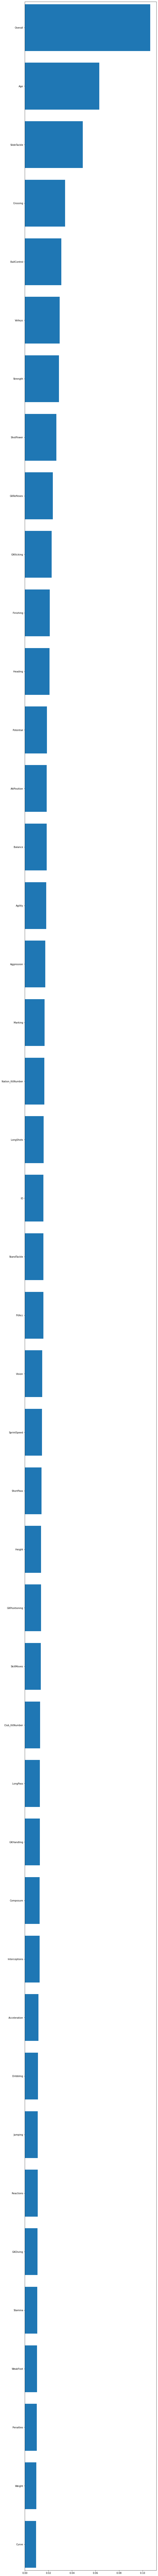

In [ ]:
features = sorted(zip(X.columns, clf.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(10)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

# create many features based on statistics per each country

In [ ]:
#only keep countries that are in the 2022 World Cup
data_df = data_df[(data_df['Country'].isin(teams_2022))]
data_df

In [ ]:
data_df = data_df.drop(columns = 'ID')

In [ ]:
data_df.columns
#which attribute features do we want out of the following column names?

In [ ]:
data_df['Nation_Position'].unique()

In [ ]:
# averaging stats of each player to get an overall 'score' for each team
average_for_teams = data_df.groupby(["Country"]).mean()
average_for_teams = average_for_teams.reset_index()
average_for_teams

In [ ]:
# median stats of each player to get an overall 'score' for each team
median_for_teams = data_df.groupby(["Country"]).median()
median_for_teams = median_for_teams.reset_index()
len(median_for_teams)

In [ ]:
# median stats of each player to get an overall 'score' for each team
max_for_teams = data_df.groupby(["Country"]).max()
max_for_teams = max_for_teams.reset_index()
len(max_for_teams)

In [ ]:
# min stats of each player to get an overall 'score' for each team
min_for_teams = data_df.groupby(["Country"]).min()
min_for_teams = min_for_teams.reset_index()
len(min_for_teams)

In [ ]:
std_for_teams = data_df.groupby(["Country"]).std()
std_for_teams = std_for_teams.reset_index()
len(std_for_teams)

#Features showing only certain positions: Goalie, for example

In [ ]:
#only goalies
goalies = data_df.loc[data_df['Nation_Position'] == 'GK']
len(goalies)

In [ ]:
#we only have 20 known goalies available
max_for_goalies = goalies.groupby("Country").max()
max_for_goalies = max_for_goalies.reset_index()
max_for_goalies

In [ ]:
data_df['PreferredPositions'].unique()

In [ ]:
#only goalies
goalies2 = data_df.loc[data_df['PreferredPositions'] == 'GK']
len(goalies2)

In [ ]:
max_for_goalies2 = goalies2.groupby("Country").max()
max_for_goalies2 = max_for_goalies2.reset_index()
max_for_goalies2

# Dataset does not identify the position each player will play in the world cup yet. However, we can look at preferred position to get a clue.

In [ ]:
data_df['Nation_Position'].value_counts()

In [ ]:
# Connect to local database

protocol = 'postgresql'
username = 'postgres'
password = 'admin'
host = 'localhost'
port = 5432
database_name = 'players_db'
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)
rds_connection_string

In [ ]:
# Checking Tables Names in PgAdmin

engine.table_names()

In [ ]:
player_info_df.to_sql(name='player_info', con=engine, if_exists='replace', index=False)


In [ ]:
matches_df.to_sql(name='matches', con=engine, if_exists='replace', index=False)

In [ ]:
averages_for_teams.to_sql(name='team_averages', con=engine, if_exists='replace', index=False)